# Построение и настройка модели случайного леса. Визуализация важности признаков.

Датасет болезней сердца https://www.kaggle.com/ronitf/heart-disease-uci

### План действий

- Предобработка, визуализации
- Построение модели случайного леса
- Визуализация важности признаков
- Сравнение с деревьями решений
- Сравнение с другими моделями

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.rcParams['figure.figsize'] = 12, 8

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
def get_classification_metrics(y_true, y_pred):
    metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]
    score = []
    for metric in metrics:
        score.append(metric(y_true, y_pred).round(3))
    return score

In [3]:
df = pd.read_csv('heart.csv')

In [4]:
print(f'Размер выборки {df.shape}')
df.sample(7)

Размер выборки (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
55,52,1,1,134,201,0,1,158,0,0.8,2,1,2,1
254,59,1,3,160,273,0,0,125,0,0.0,2,0,2,0
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2,1
271,61,1,3,134,234,0,1,145,0,2.6,1,2,2,0
117,56,1,3,120,193,0,0,162,0,1.9,1,0,3,1
275,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
99,53,1,2,130,246,1,0,173,0,0.0,2,3,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Целевая переменная

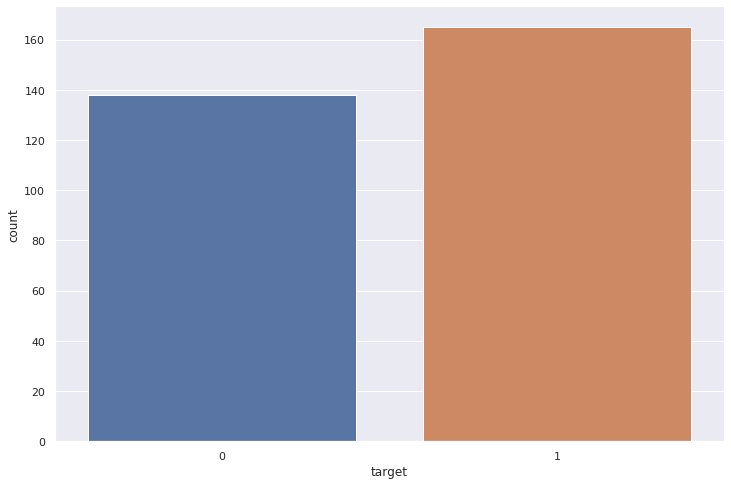

In [6]:
sns.countplot(df.target);

### Распределения признаков

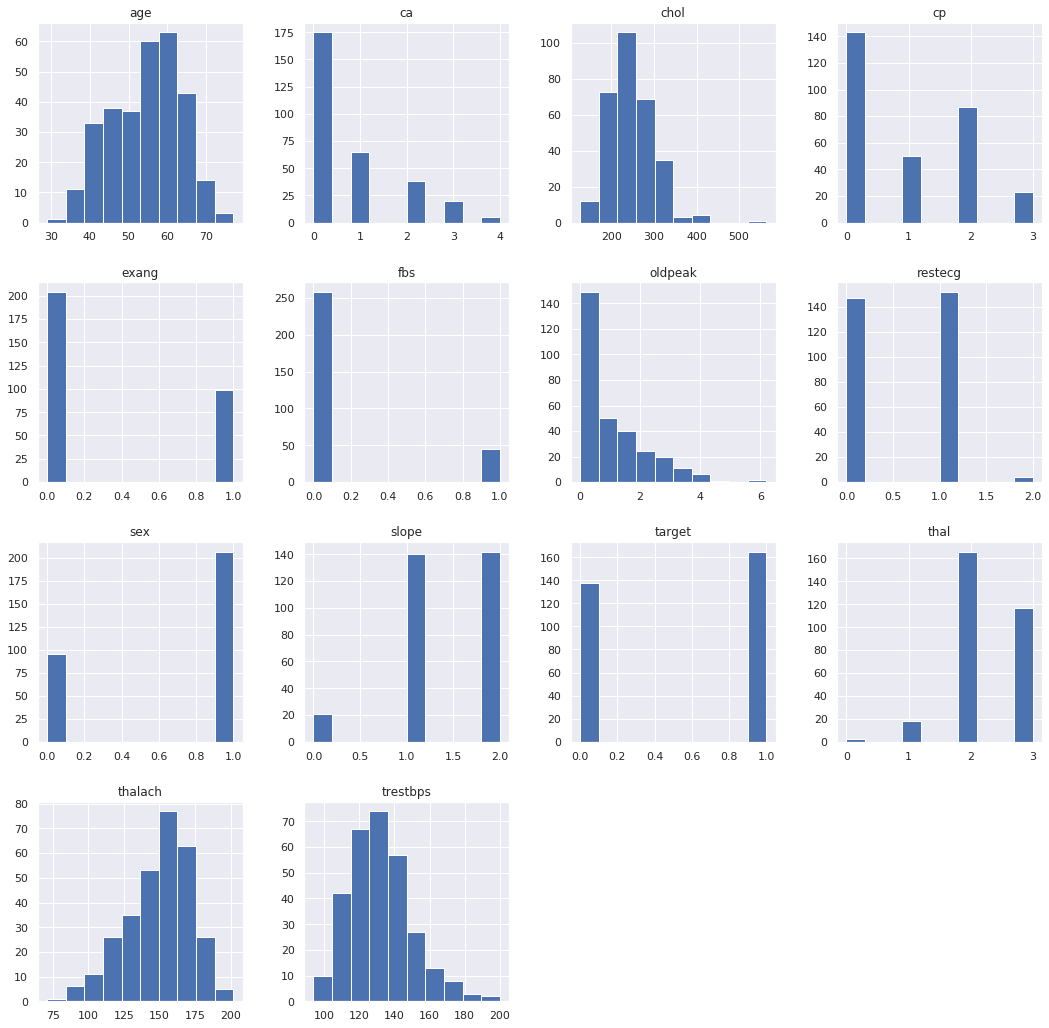

In [7]:
df.hist(figsize=[18, 18]);

### Корреляция признаков

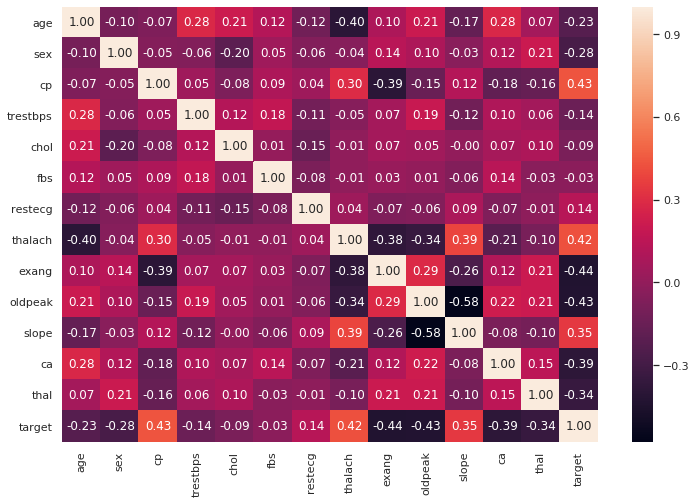

In [8]:
sns.heatmap(df.corr(), annot=True, fmt='.2f');

In [9]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Признак `cp`, категориальный, означающий тип боли в груди, заменим его на `dummies`

In [10]:
cp = pd.get_dummies(df.cp, drop_first=True, prefix='cp')
df = df.drop('cp', axis=1)
df = pd.concat([df, cp], axis=1)

In [11]:
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_1,cp_2,cp_3
0,63,1,145,233,1,0,150,0,2.3,0,0,1,1,0,0,1
1,37,1,130,250,0,1,187,0,3.5,0,0,2,1,0,1,0
2,41,0,130,204,0,0,172,0,1.4,2,0,2,1,1,0,0
3,56,1,120,236,0,1,178,0,0.8,2,0,2,1,1,0,0
4,57,0,120,354,0,1,163,1,0.6,2,0,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,1,123,1,0.2,1,0,3,0,0,0,0
299,45,1,110,264,0,1,132,0,1.2,1,0,3,0,0,0,1
300,68,1,144,193,1,1,141,0,3.4,1,2,3,0,0,0,0
301,57,1,130,131,0,1,115,1,1.2,1,1,3,0,0,0,0


In [12]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Random Forest

In [13]:
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [5, 10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 3, 5, 10, 15, 20],
    'class_weight': [None, 'balanced'],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'oob_score': [True, False]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')

predict = grid_search.predict(X_test)

index = ['RandomForest']
columns = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
quality = pd.DataFrame([get_classification_metrics(y_test, predict)], columns=columns, index=index)
quality

Best params:
===
class_weight: None
criterion: entropy
max_depth: 3
max_features: sqrt
n_estimators: 10
oob_score: False


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.803,0.837,0.818,0.828,0.8


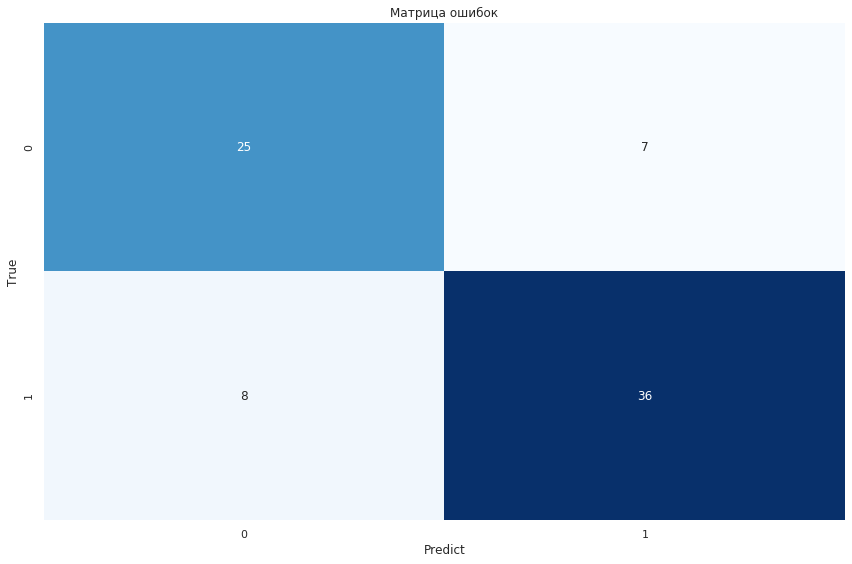

In [14]:
matrix = confusion_matrix(y_test, predict)
sns.heatmap(matrix, annot=True, cbar=None, cmap='Blues')
plt.title('Матрица ошибок')
plt.ylabel('True')
plt.xlabel('Predict')
plt.tight_layout()
plt.show()

### Важность признаков, Random Forest:

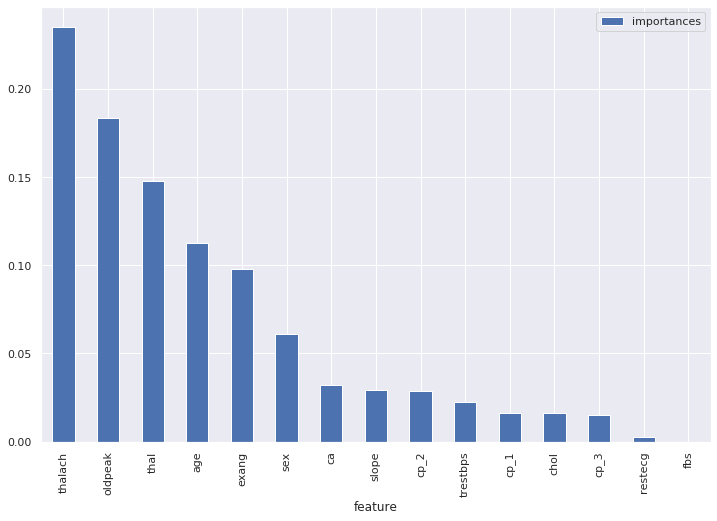

In [15]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_columns = df.drop('target', axis=1).columns
df_feature_importances = pd.DataFrame(
    {'feature': feature_columns,
    'importances': feature_importances}

)
df_feature_importances.set_index('feature', inplace=True)
df_feature_importances.sort_values('importances', ascending=False, inplace=True)
df_feature_importances.plot.bar();

### Decision Tree

In [16]:
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 1, 3, 5, 10, 15],
    'class_weight': [None, 'balanced'],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')

predict = grid_search.predict(X_test)

quality.loc['Decision Tree', :] = get_classification_metrics(y_test, predict)
quality

Best params:
===
class_weight: None
criterion: gini
max_depth: 5
max_features: None
splitter: best


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.803,0.837,0.818,0.828,0.800
Decision Tree,0.750,0.821,0.727,0.771,0.754


### Важность признаков, Decision Tree:

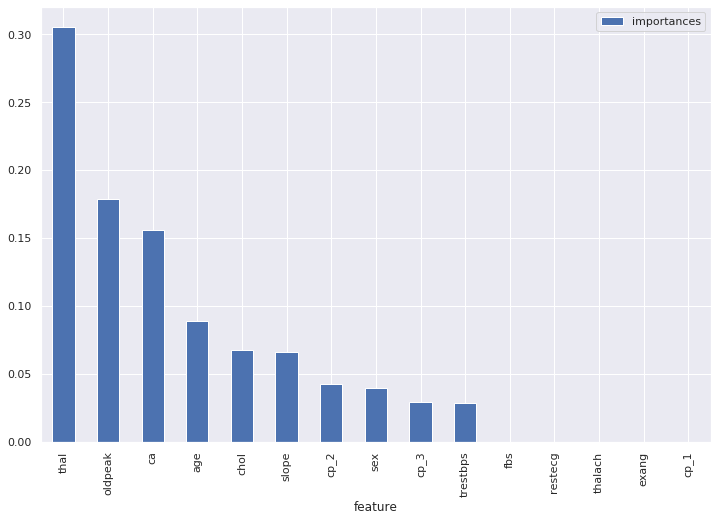

In [17]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_columns = df.drop('target', axis=1).columns
df_feature_importances = pd.DataFrame(
    {'feature': feature_columns,
    'importances': feature_importances}

)
df_feature_importances.set_index('feature', inplace=True)
df_feature_importances.sort_values('importances', ascending=False, inplace=True)
df_feature_importances.plot.bar();

### Bagging Classifier

In [18]:
model = BaggingClassifier()
param_grid = {
    'n_estimators': [1, 10, 100],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')

predict = grid_search.predict(X_test)

quality.loc['Bagging Classifier', :] = get_classification_metrics(y_test, predict)
quality

Best params:
===
bootstrap: False
bootstrap_features: True
n_estimators: 100
oob_score: False


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.803,0.837,0.818,0.828,0.800
Decision Tree,0.750,0.821,0.727,0.771,0.754
Bagging Classifier,0.803,0.822,0.841,0.831,0.795


### Extra Trees Classifier

In [19]:
model = ExtraTreesClassifier()
param_grid = {
    'n_estimators': [1, 10, 100],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'ccp_alpha': [0, 0.01, 0.1, 1],
    'max_depth': [None, 3, 5, 10],
    'oob_score': [True, False]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')

predict = grid_search.predict(X_test)

quality.loc['Extra Trees', :] = get_classification_metrics(y_test, predict)
quality

Best params:
===
bootstrap: True
ccp_alpha: 0.01
criterion: entropy
max_depth: 5
n_estimators: 100
oob_score: True


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.803,0.837,0.818,0.828,0.800
Decision Tree,0.750,0.821,0.727,0.771,0.754
Bagging Classifier,0.803,0.822,0.841,0.831,0.795
Extra Trees,0.855,0.851,0.909,0.879,0.845


### Масштабирование

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### KNN

In [21]:
model = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 50), 'p': range(1, 5)}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best params:\n===')
for name, value, in grid_search.best_params_.items():
    print(f'{name}: {value}')

predict = grid_search.predict(X_test)
quality.loc['KNN', :] = get_classification_metrics(y_test, predict)
quality

Best params:
===
n_neighbors: 12
p: 1


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.803,0.837,0.818,0.828,0.800
Decision Tree,0.750,0.821,0.727,0.771,0.754
Bagging Classifier,0.803,0.822,0.841,0.831,0.795
Extra Trees,0.855,0.851,0.909,0.879,0.845
KNN,0.789,0.818,0.818,0.818,0.784


### Итоговые метрики

In [22]:
quality.sort_values(['roc_auc', 'f1'], ascending=False)

,accuracy,precision,recall,f1,roc_auc
Extra Trees,0.855,0.851,0.909,0.879,0.845
RandomForest,0.803,0.837,0.818,0.828,0.800
Bagging Classifier,0.803,0.822,0.841,0.831,0.795
KNN,0.789,0.818,0.818,0.818,0.784
Decision Tree,0.750,0.821,0.727,0.771,0.754
